In [35]:
import numpy as np
import scipy
import scipy.stats
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import spacepy.toolbox as tb
import spacepy.plot as splot
import verify
np.random.seed(24601)
%matplotlib inline

To estimate how many ensemble members we need to estimate the prediction interval with a reasonable degree of confidence, we simulate the problem using a normal distribution of ($\mu$=-20, $\sigma$=5)

13.2689119984


/mnt/projects/anaconda3/envs/nc4/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:5408: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


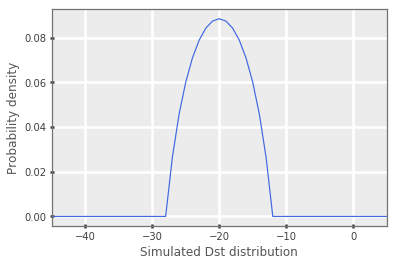

In [41]:
nmean, stddev = -20, 4
xarr = np.arange(-50,50,1)
#normdist = scipy.stats.gumbel_l.pdf(xarr, loc=nmean, scale=stddev)
normdist = scipy.stats.tukeylambda.pdf(xarr, 0.5, loc=nmean, scale=stddev)
plt.plot(xarr, normdist)
plt.xlim([-45,5])
plt.xlabel('Simulated Dst distribution')
plt.ylabel('Probability density')
#Central 95% lies between...
n025, n975 = scipy.stats.tukeylambda.interval(0.95, 0.5, loc=nmean, scale=stddev)
#n025, n975 = scipy.stats.gumbel_l.interval(0.95, loc=nmean, scale=stddev)
nwidth = n975-n025
print(nwidth)

## Testing the effect of number of samples

As we intend to use the fitted KDE to estimate the 95% prediction interval, we need to assess the uncertainty in determining a known percentile of the distribution given the number of samples. In our use case, the number of samples is the number of ensemble members. So we now sample our normal distribution 

In [44]:
def bwscott1d(data):
    npts = len(data)
    bw = npts**(-1.0/5)
    return bw*0.5

/mnt/projects/anaconda3/envs/nc4/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


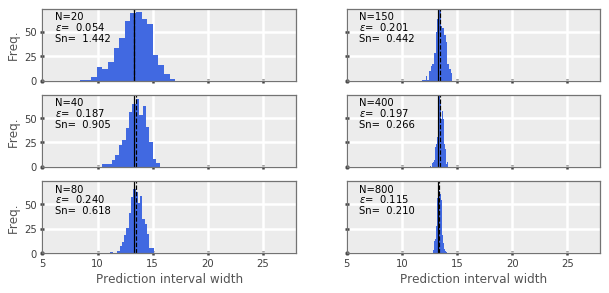

In [45]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, squeeze=True, figsize=(10,4.5))
axes = axes.T.ravel()
func025 = lambda x: kde.integrate_box_1d(-400, x)-0.025
func975 = lambda x: kde.integrate_box_1d(-400, x)-0.975
for idx, npt in enumerate([20, 40, 80, 150, 400, 800]):
    lowbound, highbound, width = [], [], []
    for it in range(500):
        #data = scipy.stats.gumbel_l.rvs(loc=nmean, scale=stddev, size=npt)
        data = scipy.stats.tukeylambda.rvs(0.5, loc=nmean, scale=stddev, size=npt)
        kde = scipy.stats.gaussian_kde(data, bw_method=bwscott1d(data))
        p025 = scipy.optimize.brentq(func025, -100, 40)
        p975 = scipy.optimize.brentq(func975, -100, 40)
        lowbound.append(p025)
        highbound.append(p975)
        width.append(p975-p025)
    binw, nbins = tb.binHisto(width)
    axes[idx].hist(width, bins=int(nbins))
    axes[idx].text(0.05, 0.85, 'N={}'.format(npt), transform=axes[idx].transAxes)
    axes[idx].set_xlim([5, 7*stddev])
    ylim = axes[idx].get_ylim()[1]
    axes[idx].vlines(nwidth, 0, ylim)
    axes[idx].vlines(np.mean(width), 0, ylim, linestyles='dashed')
    axes[idx].text(0.05, 0.7, '$\epsilon$={:7.3f}'.format(np.abs(nwidth-np.mean(width))), transform=axes[idx].transAxes)
    axes[idx].text(0.05, 0.55, 'Sn={:7.3f}'.format(verify.Sn(width)), transform=axes[idx].transAxes)
    axes[idx].set_ylim([0, ylim])
    if idx<=2: axes[idx].set_ylabel('Freq.')
    if idx==2 or idx==5: axes[idx].set_xlabel('Prediction interval width')

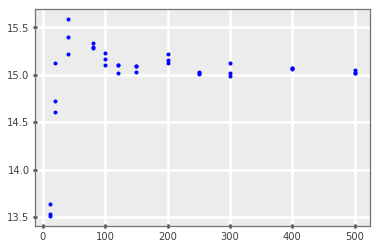

In [30]:
meanwidth = []
vals = [12,20,40,80,100,120,150,200,250,300,400,500]*3
for idx, npt in enumerate(vals):
    lowbound, highbound, width = [], [], []
    for it in range(400):
        data = scipy.stats.gumbel_l.rvs(loc=nmean, scale=stddev, size=npt)
        kde = scipy.stats.gaussian_kde(data, bw_method=bwscott1d(data))
        p025 = scipy.optimize.brentq(func025, -100, 40)
        p975 = scipy.optimize.brentq(func975, -100, 40)
        lowbound.append(p025)
        highbound.append(p975)
        width.append(p975-p025)
    meanwidth.append(np.mean(width))
plt.plot(vals, meanwidth, 'b.')

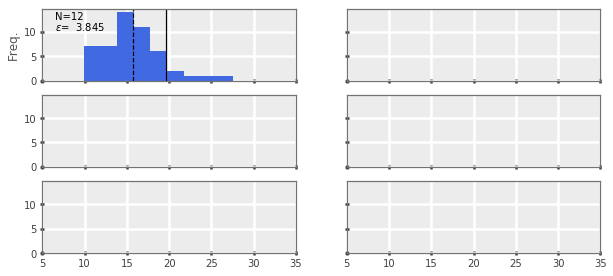

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, squeeze=True, figsize=(10,4.5))
axes = axes.T.ravel()

pfunc = lambda x: np.exp(kde.score_samples(x))
func025 = lambda x: scipy.integrate.quad(pfunc, -200, x, epsrel=1.49e-03)[0]-0.025
func975 = lambda x: scipy.integrate.quad(pfunc, -200, x, epsrel=1.49e-03)[0]-0.975
for idx, npt in enumerate([12]): #, 20, 40, 120, 200, 400]):
    lowbound, highbound, width = [], [], []
    for it in range(50):
        data = np.random.normal(loc=-20, scale=stddev, size=npt)
        bwscott = npt**(-1.0/5)
        kde = KernelDensity(kernel='gaussian', bandwidth=bwscott).fit(data[:, np.newaxis])
        p025 = scipy.optimize.brentq(func025, -60, 30)
        p975 = scipy.optimize.brentq(func975, -60, 30)
        lowbound.append(p025)
        highbound.append(p975)
        width.append(p975-p025)
    binw, nbins = tb.binHisto(width)
    axes[idx].hist(width, bins=int(nbins))
    axes[idx].text(0.05, 0.85, 'N={}'.format(npt), transform=axes[idx].transAxes)
    axes[idx].set_xlim([5, 7*stddev])
    ylim = axes[idx].get_ylim()[1]
    axes[idx].vlines(nwidth, 0, ylim)
    axes[idx].vlines(np.mean(width), 0, ylim, linestyles='dashed')
    axes[idx].text(0.05, 0.7, '$\epsilon$={:7.3f}'.format(np.abs(nwidth-np.mean(width))), transform=axes[idx].transAxes)
    axes[idx].set_ylim([0, ylim])
    if idx<=2: axes[idx].set_ylabel('Freq.')
    if idx==2 or idx==5: axes[idx].set_xlabel('Prediction interval width')


In [52]:
print(it)

20


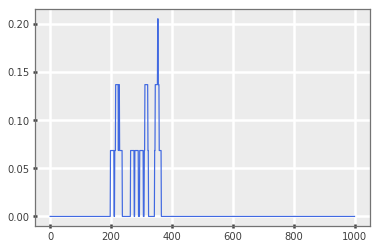

In [48]:
plt.plot(np.exp(kde.score_samples(np.linspace(-50, 50, 1000)[:, np.newaxis])))